$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

In [61]:
import gdown
import os
from PIL import Image
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


# `+` Seed Value

In [2]:
SEED = 907
BATCH_SIZE=8
EPOCHS=50

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [3]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=16b03470-808a-4051-bae5-fc3ba306063b
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 86.4MB/s]


'Lung_Data.zip'

In [4]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [5]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [6]:
# Training Dataset
gray_train,gray_valid=image_dataset_from_directory("/content/Lung_Data_PNG/grey",color_mode="grayscale",batch_size=BATCH_SIZE,image_size=(512,512),validation_split=0.15,labels=None,subset="both",seed=SEED)


Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [7]:
# Validation Dataset
mask_train,mask_valid=image_dataset_from_directory("/content/Lung_Data_PNG/mask",color_mode="grayscale",labels=None,validation_split=0.15,image_size=(512,512),batch_size=BATCH_SIZE,seed=SEED,subset="both")



Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

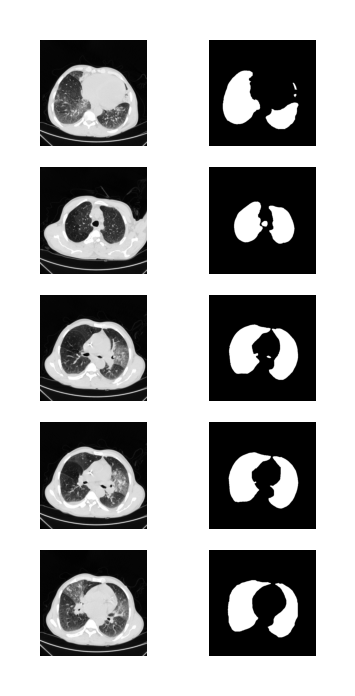

In [8]:
# Preview Images
plt.figure(figsize=(1, 2), dpi=400)
for images, masks in zip(gray_train.take(4), mask_train.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')


## `+` Set Global Parameters

In [9]:
# Hyperparameters
BATCH_SIZE  =8
EPOCHS      =50

## `i` Model Design

In [62]:
from keras.layers import concatenate ,Conv2D,Conv2DTranspose,MaxPooling2D,Dense,Input,BatchNormalization,Activation,Dropout,Flatten,Reshape
from keras.layers import Rescaling,Lambda
from keras.models import Sequential,Model

In [11]:
def conv_2d(inputs,n_filters,kernel_size=(3,3)):
  x=Conv2D(n_filters,kernel_size,padding="same",activation="relu",kernel_initializer='he_normal')(inputs)
  x=Conv2D(n_filters,kernel_size,padding="same",activation="relu",kernel_initializer='he_normal')(x)
  return x

In [12]:
def down_sampling(inputs,n_filters,max_pooling=(2,2)):
  f=conv_2d(inputs,n_filters)
  p = MaxPooling2D(pool_size=max_pooling)(f)
  return f,p


In [13]:
def up_sampling(inputs,n_filters,skip_features,kernel_size=(3,3)):
  x=Conv2DTranspose(n_filters,kernel_size=kernel_size,strides=2,padding="same")(inputs)
  x = concatenate([x, skip_features])
  x=conv_2d(x,n_filters)
  return x

In [14]:
inputs=Input((512,512,1))

###encoding
f1,p1=down_sampling(inputs,32)
f2,p2=down_sampling(p1,64)
f3,p3=down_sampling(p2,128)
f4,p4=down_sampling(p3,256)

###bottleneck
bottleneck=conv_2d(p4,512)

###decoding
u1=up_sampling(bottleneck,256,f4)
u2=up_sampling(u1,128,f3)
u3=up_sampling(u2,64,f2)
u4=up_sampling(u3,32,f1)


#out_put
output=Conv2D(1,(1,1),strides=1,padding="same",activation="sigmoid")(u4)


model=Model(inputs,output,name="segmenation")

model.summary()





Model: "segmenation"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [17]:
segment_train = tf.data.Dataset.zip(gray_train, mask_train.map(lambda x: Rescaling(1./255)(x)))
segment_val = tf.data.Dataset.zip(gray_valid, mask_valid.map(lambda x: Rescaling(1./255)(x)))

In [18]:
history=model.fit(x=segment_train,epochs=EPOCHS,validation_data=segment_val,steps_per_epoch=gray_train.cardinality().numpy(),
    validation_steps=gray_valid.cardinality().numpy(),callbacks=[early_stopping])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7285 - loss: 58.5390 - val_accuracy: 0.8802 - val_loss: 1.4784
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 640ms/step - accuracy: 0.8543 - loss: 0.9536 - val_accuracy: 0.8655 - val_loss: 0.5083
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 662ms/step - accuracy: 0.8861 - loss: 0.4587 - val_accuracy: 0.8931 - val_loss: 0.3869
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 658ms/step - accuracy: 0.8999 - loss: 0.3681 - val_accuracy: 0.8443 - val_loss: 0.4474
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.8907 - loss: 0.4545 - val_accuracy: 0.8838 - val_loss: 1.0705
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 641ms/step - accuracy: 0.8748 - loss: 0.6367 - val_accuracy: 0.8961 - val_loss: 0.3198
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 654ms/step - accuracy: 0.9037 - loss: 0.2496 - val_accuracy: 0.9217 - val_loss: 0.1723
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 648ms/step - accuracy: 0.9237 - loss: 0.1911 - val_accur

In [19]:
model.evaluate(segment_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9958 - loss: 0.0105


[0.010333442129194736, 0.9959022998809814]

## `ii` Model Compilation & Training

## `iii` Model Evaluation

In [20]:
model.evaluate(segment_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9958 - loss: 0.0105


[0.010333441197872162, 0.9959022998809814]

## `iv` Result Visualization

In [24]:
print(history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


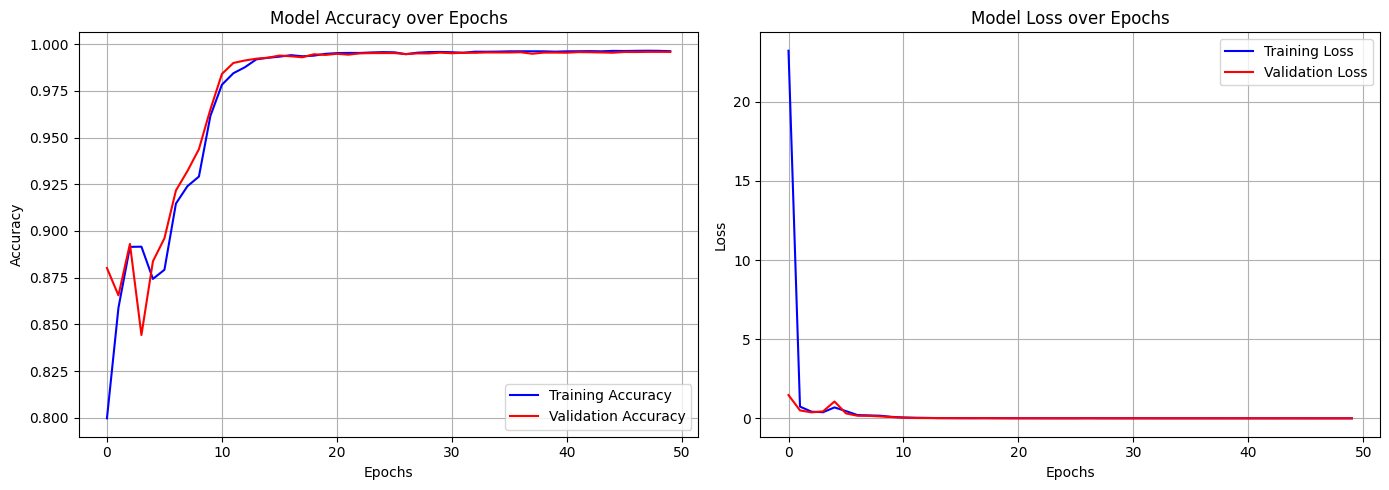

In [28]:
import matplotlib.pyplot as plt

# Extract values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [34]:
def plot_predictions(model, validation_data, num_samples=2, thresholds=[0.4, 0.5, 0.6, 0.7]):

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    # Get samples from validation data
    validation_iter = iter(validation_data)
    samples = []

    for _ in range(num_samples):
        try:
            sample = next(validation_iter)
            samples.append(sample)
        except StopIteration:
            break

    # Create figure
    num_cols = 2 + len(thresholds)  # Input + True Mask + Pred Masks for each threshold
    fig = plt.figure(figsize=(num_cols * 3.5, len(samples) * 3))
    gs = gridspec.GridSpec(len(samples), num_cols)

    # Plot each sample
    for i, (images, masks) in enumerate(samples):
        # Make predictions
        predictions = model.predict(images)

        # Process each image in the batch
        for j in range(min(1, len(images))):  # Display only the first image from each batch
            # Get image and mask
            image = images[j].numpy()
            mask = masks[j].numpy()
            pred = predictions[j]

            # Plot input image
            ax = plt.subplot(gs[i, 0])
            ax.imshow(image, cmap='gray')
            ax.set_title('Input Image')
            ax.axis('off')

            # Plot true mask
            ax = plt.subplot(gs[i, 1])
            ax.imshow(mask, cmap='gray')
            ax.set_title('True Mask')
            ax.axis('off')

            # Plot predicted masks at different thresholds
            for k, threshold in enumerate(thresholds):
                ax = plt.subplot(gs[i, k+2])
                pred_mask = (pred >= threshold).astype(np.float32)
                ax.imshow(pred_mask, cmap='gray')
                ax.set_title(f'Pred Mask @th={threshold}')
                ax.axis('off')

    plt.tight_layout()
    return fig

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


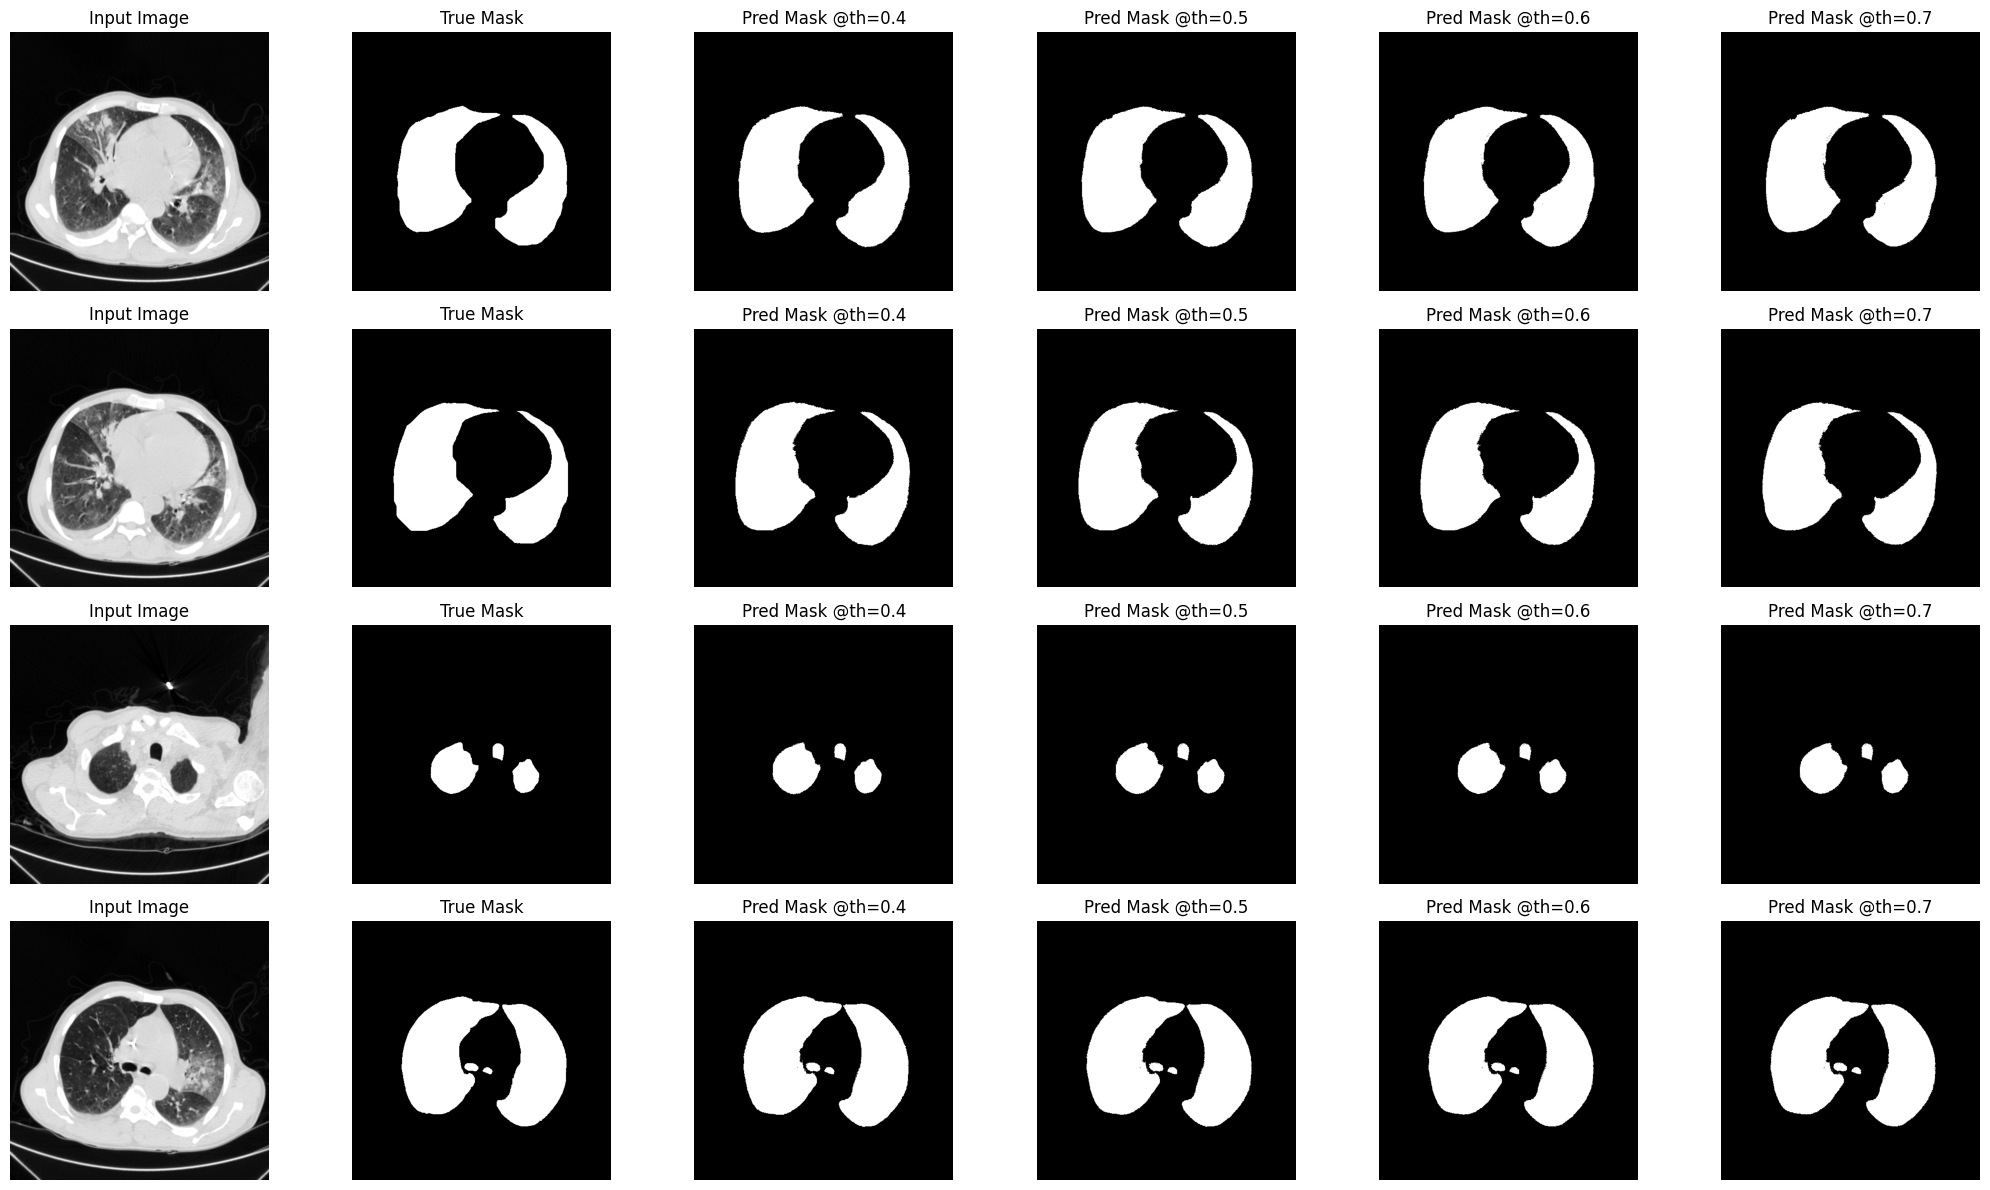

In [36]:
# Import matplotlib for displaying the figure
import matplotlib.pyplot as plt

# Call the plot_predictions function with your model and validation dataset
fig = plot_predictions(
    model=model,                  # Your trained segmentation model
    validation_data=segment_val,  # Your validation dataset
    num_samples=5,                # Number of samples to plot
    thresholds=[0.4, 0.5, 0.6, 0.7]  # Thresholds to apply
)

# Display the figure
plt.show()

# Optionally save the figure to a file
# fig.savefig('mask_prediction_results.png', dpi=300, bbox_inches='tight')

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [63]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  67.4M      0  0:00:11  0:00:11 --:--:--  102M


In [64]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: PetImages/Cat  PetImages/Dog


In [66]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [67]:
# Training/Validation Dataset
train, val = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.15,
                                                subset="both")


Found 23410 files belonging to 2 classes.
Using 19899 files for training.
Using 3511 files for validation.


### Preview the Images

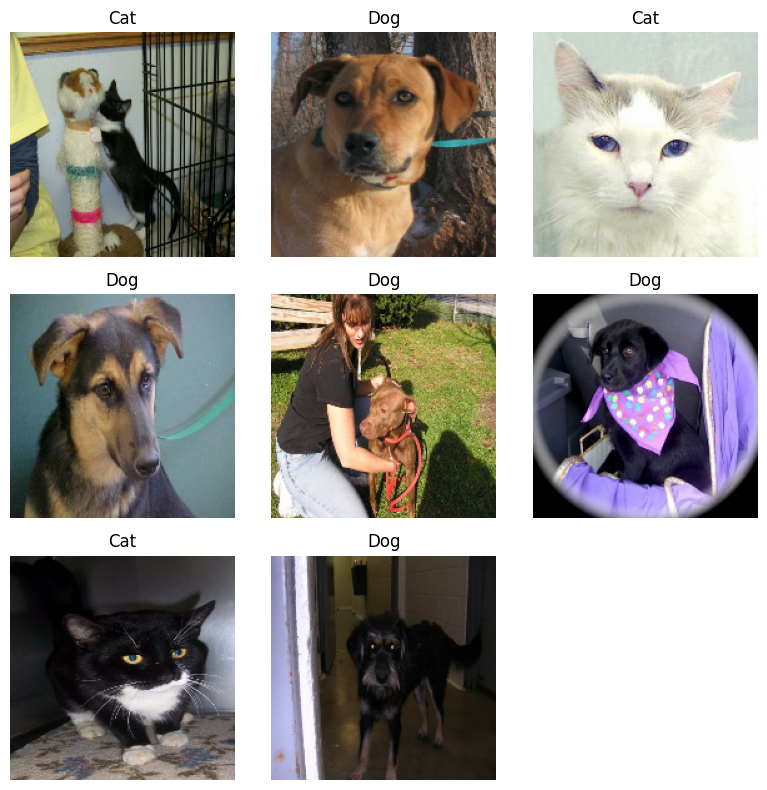

In [68]:
for images, labels in train.take(1):
    plt.figure(figsize=(8, 8))
    batch_size = images.shape[0]
    n = min(batch_size, 9)

    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(f'{["Cat", "Dog"][labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


## `+` Set Global Parameters

In [69]:
# Hyperparameters
BATCH_SIZE  = 8
EPOCHS      =15

## `i` Model Design

In [70]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [71]:
for layer in conv_base.layers:
  layer.trainable = False
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [72]:
input=Input((180,180,3))
x = keras.applications.vgg16.preprocess_input(input)
x = conv_base(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(input, output)

In [73]:
model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

## `ii` Model Compilation & Training

In [75]:
history = model.fit(
    train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val,
    callbacks=[early_stopping])

Epoch 1/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 122s 48ms/step - accuracy: 0.9407 - loss: 2.2547 - val_accuracy: 0.9724 - val_loss: 0.1277
Epoch 2/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 140s 48ms/step - accuracy: 0.9721 - loss: 0.1339 - val_accuracy: 0.9701 - val_loss: 0.1403
Epoch 3/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 113s 46ms/step - accuracy: 0.9726 - loss: 0.1545 - val_accuracy: 0.9732 - val_loss: 0.1174
Epoch 4/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 146s 47ms/step - accuracy: 0.9716 - loss: 0.1748 - val_accuracy: 0.9809 - val_loss: 0.1071
Epoch 5/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 138s 46ms/step - accuracy: 0.9742 - loss: 0.1573 - val_accuracy: 0.9781 - val_loss: 0.0844
Epoch 6/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 146s 47ms/step - accuracy: 0.9749 - loss: 0.1132 - val_accuracy: 0.9786 - val_loss: 0.0996
Epoch 7/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 138s 46ms/step - accuracy: 0.9771 - loss: 0.1017 - val_accuracy: 0.9775 - val_loss: 0.1417
Epoch 8/15
2488/2488 ━━━━━━━━━━━━━━━━━━━━ 118s 47ms/step - accuracy: 

## `iii` Model Evaluation

In [76]:
model.evaluate(val)

439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9778 - loss: 0.0885


[0.08439826220273972, 0.9780689477920532]

## `iv` Result Visualization

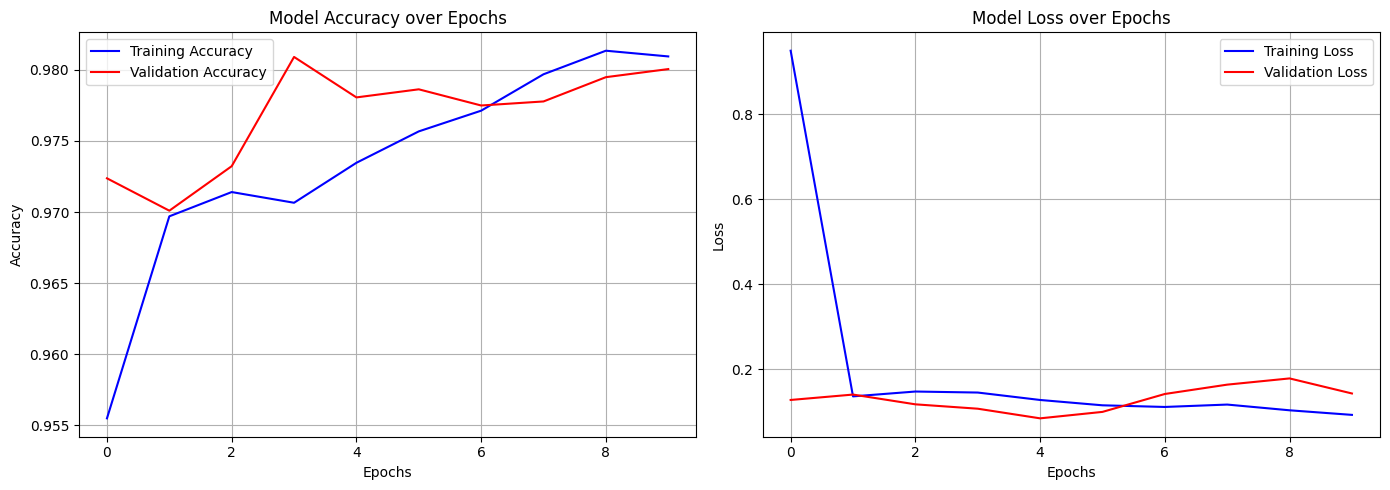

In [77]:
# Plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Extract values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

In [99]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

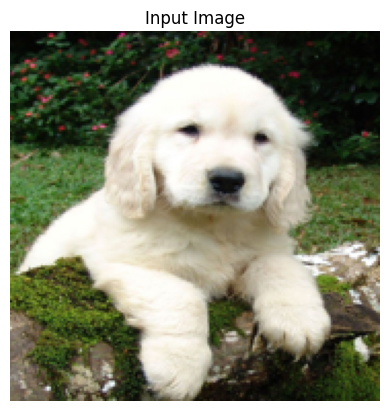

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: Dog 🐶 (Confidence: 100.00%)


In [97]:
url = 'https://upload.wikimedia.org/wikipedia/commons/6/6e/Golde33443.jpg'  # Example dog
response = requests.get(url)
img = Image.open(BytesIO(response.content)).resize((180, 180))  # Match model's input shape

# Convert to RGB (your model expects 3 channels)
img = img.convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess
img_array = img_to_array(img)                # Shape: (180, 180, 3)
img_array = img_array / 255.0                # Normalize
img_batch = np.expand_dims(img_array, axis=0)  # Shape: (1, 180, 180, 3)

# Predict using your model
prediction = model.predict(img_batch)[0][0]

# Interpret result
if prediction >= 0.5:
    print(f"Prediction: Cat 🐱 (Confidence: {prediction*100:.2f}%)")
else:
    print(f"Prediction: Dog 🐶 (Confidence: {(1 - prediction)*100:.2f}%)")

----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$